In [3]:
!apt install -y ffmpeg
!pip install eyed3
!pip install pydub
!pip install pyAudioAnalysis

import os
import tensorflow as tf
import numpy as np
import pandas as pd
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [12]:
def preProcess(fileName):
    # Extracting wav file data using read_audio_file
    [Fs, x] = audioBasicIO.read_audio_file(fileName)

    # If double channel data then take the mean
    if len(x.shape) > 1 and x.shape[1] == 2:
        x = np.mean(x, axis=1, keepdims=True)
    else:
        x = x.reshape(x.shape[0], 1)

    # Extract the raw chromagram data; expected dimension is [m, ] not [m, 1]
    F, f_names = ShortTermFeatures.feature_extraction(
        x[:, 0],
        Fs, 0.050 * Fs,
        0.025 * Fs
    )

    return (f_names, F)

# Example usage
file_name = "/content/1kHz_44100Hz_16bit_05sec.wav"
feature_name, features = preProcess(file_name)

# Print feature names and shape of features
print("Feature Names:", feature_name)
print("Features Shape:", features.shape)


Feature Names: ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std', 'delta zcr', 'delta energy', 'delta energy_entropy', 'delta spectral_centroid', 'delta spectral_spread', 'delta spectral_entropy', 'delta spectral_flux', 'delta spectral_rolloff', 'delta mfcc_1', 'delta mfcc_2', 'delta mfcc_3', 'delta mfcc_4', 'delta mfcc_5', 'delta mfcc_6', 'delta mfcc_7', 'delta mfcc_8', 'delta mfcc_9', 'delta mfcc_10', 'delta mfcc_11', 'delta mfcc_12', 'delta mfcc_13', 'delta chroma_1', 'delta chroma_2', 'delta chroma_3', 'delta chroma_4', 'delta chroma_5', 'delta chroma_6', 'delta chroma_7', 'delta chroma_8', 'delta chroma_9', 'de

In [5]:
def getChromagram( audioData ):
    # chronograph_1
    temp_data =  audioData[ 21 ].reshape( 1, audioData[ 21 ].shape[0] )
    chronograph = temp_data

    # looping through the next 11 stacking them vertically
    for i in range( 22, 33 ):
        temp_data =  audioData[ i ].reshape( 1, audioData[ i ].shape[0] )
        chronograph = np.vstack( [ chronograph,  temp_data ] )

    return chronograph

In [6]:
def getNoteFrequency( chromagram ):

    # Total number of time frames in the current sample
    numberOfWindows = chromagram.shape[1]

    # Taking the note with the highest amplitude
    freqVal = chromagram.argmax( axis = 0 )

    # Converting the freqVal vs time to freq count
    histogram, bin = np.histogram( freqVal, bins = 12 )

    # Normalizing the distribution by the number of time frames
    normalized_hist = histogram.reshape( 1, 12 ).astype( float ) / numberOfWindows

    return normalized_hist

In [7]:
def plotHeatmap( chromagraph, smallSample = True ):

    notesLabels = [ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ]

    fig, axis = plt.subplots()

    if smallSample:
        im = axis.imshow( chromagram[ :, 0 : 25 ], cmap = "YlGn" )
    else:
        im = axis.imshow( chromagram )

    cbar = axis.figure.colorbar(im, ax = axis,  cmap = "YlGn")
    cbar.ax.set_ylabel("Amplitude", rotation=-90, va="bottom")

    axis.set_yticks( np.arange( len(notesLabels) ) )
    axis.set_yticklabels(notesLabels)

    axis.set_title( "chromagram" )

    fig.tight_layout()
    _ = plt.show()

In [8]:
def noteFrequencyPlot( noteFrequency, smallSample = True ):

    fig, axis = plt.subplots(1, 1, sharey=True )

    axis.plot( np.arange( 1, 13 ), noteFrequency[0, :] )

    _ = plt.show()

In [17]:
fileList = []

def getDataset(filePath):
    # Initialize an empty list to store rows of the DataFrame
    data_rows = []
    columns = ["G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A"]

    for root, dirs, filenames in os.walk(filePath):
        for file in filenames:
            fileList.append(file)

            # Preprocess the file
            feature_name, features = preProcess(os.path.join(filePath, file))

            # Get the chromagram and note frequency
            chromagram = getChromagram(features)
            noteFrequency = getNoteFrequency(chromagram)

            # Append the note frequency to the data rows
            data_rows.append(noteFrequency[0, :])

    # Create the DataFrame from collected rows
    data = pd.DataFrame(data_rows, columns=columns)

    return data




In [13]:
feature_name, features = preProcess( "/content/1kHz_44100Hz_16bit_05sec.wav" )


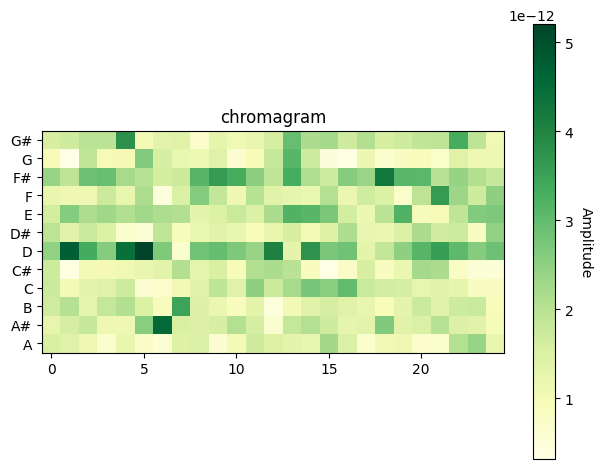

In [14]:
chromagram = getChromagram( features )
plotHeatmap( chromagram )

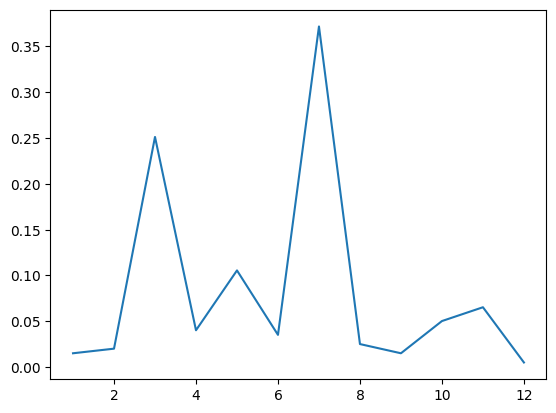

In [15]:
noteFrequency = getNoteFrequency( chromagram )
noteFrequencyPlot( noteFrequency )

In [18]:
data = getDataset( "/content/1kHz_44100Hz_16bit_05sec.wav" )


In [19]:
data


,G#,G,F#,F,E,D#,D,C#,C,B,A#,A


In [20]:
# Number of cluster we wish to divide the data into( user tunable )
k = 3

# Max number of allowed iterations for the algorithm( user tunable )
epochs = 2000

In [37]:
def initilizeCentroids(data, k):
    if k > data.shape[0]:
        raise ValueError("Number of clusters (k) cannot exceed number of data points.")
    centroids = data.values[0:k]
    return centroids

In [38]:
def assignCentroids(X, C):
    expanded_vectors = tf.expand_dims(X, 0)
    expanded_centroids = tf.expand_dims(C, 1)
    distance = tf.math.reduce_sum(tf.math.square(tf.math.subtract(expanded_vectors, expanded_centroids)), axis=2)
    return tf.math.argmin(distance, axis=0)

# Utility to recalculate centroids
def reCalculateCentroids(X, X_labels, k):
    sums = tf.math.unsorted_segment_sum(X, X_labels, k)
    counts = tf.math.unsorted_segment_sum(tf.ones_like(X), X_labels, k)
    counts = tf.where(tf.equal(counts, 0), tf.ones_like(counts), counts)  # Avoid division by zero
    return tf.math.divide(sums, counts)

In [39]:
data = pd.DataFrame({
    'x1': np.random.rand(10),
    'x2': np.random.rand(10)
})
data = data.apply(pd.to_numeric, errors='coerce')  # Ensure numeric
data = data.dropna()  # Drop rows with NaN values
data = data.astype('float32')  # Convert to float32 for TensorFlow

# Verify the data
print(data.head())
print("Data shape:", data.shape)

# Parameters
k = 3  # Number of clusters
epochs = 10

# Convert to TensorFlow variables
X = tf.Variable(data.values, dtype=tf.float32, name="X")
C = tf.Variable(tf.cast(initilizeCentroids(data, k), dtype=tf.float32), name="C")

# Validate Tensor shapes
print("X shape:", X.shape)
print("C shape:", C.shape)

# K-means clustering loop
for epoch in range(epochs):
    X_labels = assignCentroids(X, C)
    print(f"Epoch {epoch}, Labels:\n", X_labels.numpy())  # Debug labels
    C = reCalculateCentroids(X, X_labels, k)
    print(f"Epoch {epoch}, Centroids:\n", C.numpy())  # Debug centroids

         x1        x2
0  0.940604  0.054314
1  0.036627  0.419179
2  0.282115  0.581665
3  0.514998  0.271916
4  0.348262  0.156362
Data shape: (10, 2)
X shape: (10, 2)
C shape: (3, 2)
Epoch 0, Labels:
 [0 1 2 2 1 2 1 2 2 2]
Epoch 0, Centroids:
 [[0.94060415 0.05431435]
 [0.24047108 0.19559282]
 [0.320214   0.5732886 ]]
Epoch 1, Labels:
 [0 1 2 1 1 2 1 2 2 1]
Epoch 1, Centroids:
 [[0.94060415 0.05431435]
 [0.33294064 0.20341757]
 [0.2444985  0.7523556 ]]
Epoch 2, Labels:
 [0 1 2 1 1 2 1 2 2 1]
Epoch 2, Centroids:
 [[0.94060415 0.05431435]
 [0.33294064 0.20341757]
 [0.2444985  0.7523556 ]]
Epoch 3, Labels:
 [0 1 2 1 1 2 1 2 2 1]
Epoch 3, Centroids:
 [[0.94060415 0.05431435]
 [0.33294064 0.20341757]
 [0.2444985  0.7523556 ]]
Epoch 4, Labels:
 [0 1 2 1 1 2 1 2 2 1]
Epoch 4, Centroids:
 [[0.94060415 0.05431435]
 [0.33294064 0.20341757]
 [0.2444985  0.7523556 ]]
Epoch 5, Labels:
 [0 1 2 1 1 2 1 2 2 1]
Epoch 5, Centroids:
 [[0.94060415 0.05431435]
 [0.33294064 0.20341757]
 [0.2444985  0.7523